In [1]:
import torch
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

from matplotlib import cm
import numpy as np
import copy

import time
torch.manual_seed(1)  # reproducible

In [2]:
class Net(nn.Module):
    def __init__(self,inp,out, activation, num_hidden_units=100, num_layers=1):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(inp, num_hidden_units, bias=True)
        torch.nn.Dropout(0.3)
        self.fc2 = nn.ModuleList()
        for i in range(num_layers):
            self.fc2.append(nn.Linear(num_hidden_units, num_hidden_units, bias=True))
            torch.nn.Dropout(0.3)
        self.fc3 = nn.Linear(num_hidden_units, out, bias=True)
        self.activation = activation

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        for fc in self.fc2:
            x = fc(x)
            x = self.activation(x)
        x = self.fc3(x)
        return x

    def predict(self, x):
        self.eval()
        y = self(x)
        x = x.cpu().numpy().flatten()
        y = y.cpu().detach().numpy().flatten()
        return [x, y]


In [3]:
def plotLoss(lossTotal, lossRegular, lossDerivatives):

    fig, ax = plt.subplots(1, 1, dpi=120)
    plt.semilogy(lossTotal / lossTotal[0], label='Total loss')
    plt.semilogy(lossRegular[:, 0] / lossRegular[0], label='Regular loss')
    plt.semilogy(lossDerivatives[:, 0] / lossDerivatives[0], label='Derivatives loss')
    ax.set_xlabel("epochs")
    ax.set_ylabel("L/L0")
    ax.legend()
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    #plt.savefig("figures/Loss.png")
    plt.show()

In [4]:
def train(lam1, loader, EPOCH, BATCH_SIZE):
    state = copy.deepcopy(net.state_dict())
    best_loss = np.inf
    

    lossTotal = np.zeros((EPOCH, 1))
    lossRegular = np.zeros((EPOCH, 1))
    lossDerivatives = np.zeros((EPOCH, 1))
    
    n = np.array(lam1).shape[0]
    
    # start training
    for epoch in range(EPOCH):
        epoch_mse0 = 0.0
        epoch_mse1 = 0.0
        lamda = lam1[epoch%n]

        for step, (batch_x, batch_y) in enumerate(loader):  # for each training step
            
            b_x = Variable(batch_x)
            b_y = Variable(batch_y)


            net.eval()
            b_x.requires_grad = True

            output0 = net(b_x)
            output0.sum().backward(retain_graph=True, create_graph=True)
            output1 = b_x.grad
            b_x.requires_grad = False

            net.train()

            mse0 = loss_func(output0, b_y[:,0:1])
            mse1 = loss_func(output1, b_y[:,1:17])
            epoch_mse0 += mse0.item() * BATCH_SIZE
            epoch_mse1 += mse1.item() * BATCH_SIZE

            loss = mse0 + lamda * mse1


            optimizer.zero_grad()  # clear gradients for next train
            loss.backward()  # backpropagation, compute gradients
            optimizer.step()  # apply gradients

        scheduler.step()
        epoch_mse0 /= num_data
        epoch_mse1 /= num_data
        epoch_loss = epoch_mse0+lamda*epoch_mse1

        y_pred = output0
        
        lossTotal[epoch] = epoch_loss
        lossRegular[epoch] = epoch_mse0
        lossDerivatives[epoch] = epoch_mse1
        if epoch%2==0:
            print('epoch', epoch,
              'lr', '{:.7f}'.format(optimizer.param_groups[0]['lr']),
              'mse0', '{:.5f}'.format(epoch_mse0),
              'mse1', '{:.5f}'.format(epoch_mse1),
              'loss', '{:.5f}'.format(epoch_loss))
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            state = copy.deepcopy(net.state_dict())
    #state = copy.deepcopy(net.state_dict())
    print('Best score:', best_loss)
    return state, lossTotal, lossRegular, lossDerivatives

In [5]:
# Load both transonic and subsonic data
X_subTr = np.loadtxt('X_subTr.dat')
X_subV = np.loadtxt('X_subV.dat')
y_subCdTr = (np.loadtxt('y_subCdTr.dat')).reshape((-1,1))
y_subCdV = (np.loadtxt('y_subCdV.dat')).reshape((-1,1))
dy_subCdTr = np.loadtxt('dy_subCdTr.dat')
dy_subCdV = np.loadtxt('dy_subCdV.dat')
XTr = X_subTr
XV = X_subV
yTr = y_subCdTr
yV = y_subCdV
dyTr = dy_subCdTr
dyV = dy_subCdV
x_tr_ts=torch.from_numpy(XTr).float()
y_tr_ts=torch.from_numpy(yTr).float()
x_va_ts=torch.from_numpy(XV).float()
y_va_ts=torch.from_numpy(yV).float()
dy_tr_ts = torch.from_numpy(dyTr).float()         
dy_va_ts = torch.from_numpy(dyTr).float() 
print(np.shape(y_tr_ts))
print(np.shape(dy_tr_ts))
print(np.shape(torch.from_numpy(dyTr[:,0])))

train_y = torch.cat([y_tr_ts, dy_tr_ts], dim = 1).squeeze(1)
print(np.shape(train_y ))
train_y = torch.cat([y_tr_ts, dy_tr_ts], dim = 1)
print(np.shape(train_y ))

torch.Size([42039, 1])
torch.Size([42039, 16])
torch.Size([42039])
torch.Size([42039, 17])
torch.Size([42039, 17])


In [6]:
train_y = torch.cat([y_tr_ts, dy_tr_ts], dim = 1)
train_y.shape

torch.Size([42039, 17])

16
epoch 0 lr 0.0000100 mse0 10.31399 mse1 4.48312 loss 10.31399
epoch 2 lr 0.0000100 mse0 2.57601 mse1 4.48079 loss 2.57601
epoch 4 lr 0.0000100 mse0 0.37772 mse1 4.48660 loss 0.37772
epoch 6 lr 0.0000100 mse0 0.13020 mse1 4.48821 loss 0.13020
epoch 8 lr 0.0000100 mse0 0.07282 mse1 4.49091 loss 0.07282
epoch 10 lr 0.0000100 mse0 0.04727 mse1 4.49151 loss 0.04727
epoch 12 lr 0.0000100 mse0 0.03734 mse1 4.49264 loss 0.03734
epoch 14 lr 0.0000100 mse0 0.03403 mse1 4.49342 loss 0.03403
epoch 16 lr 0.0000100 mse0 0.03261 mse1 4.49353 loss 0.03261
epoch 18 lr 0.0000100 mse0 0.03114 mse1 4.49043 loss 0.03114
epoch 20 lr 0.0000100 mse0 0.02995 mse1 4.48933 loss 0.02995
epoch 22 lr 0.0000100 mse0 0.02870 mse1 4.48748 loss 0.02870
epoch 24 lr 0.0000100 mse0 0.02759 mse1 4.48634 loss 0.02759
epoch 26 lr 0.0000100 mse0 0.02660 mse1 4.48565 loss 0.02660
epoch 28 lr 0.0000100 mse0 0.02571 mse1 4.48532 loss 0.02571
epoch 30 lr 0.0000100 mse0 0.02475 mse1 4.48580 loss 0.02475
epoch 32 lr 0.0000100 ms

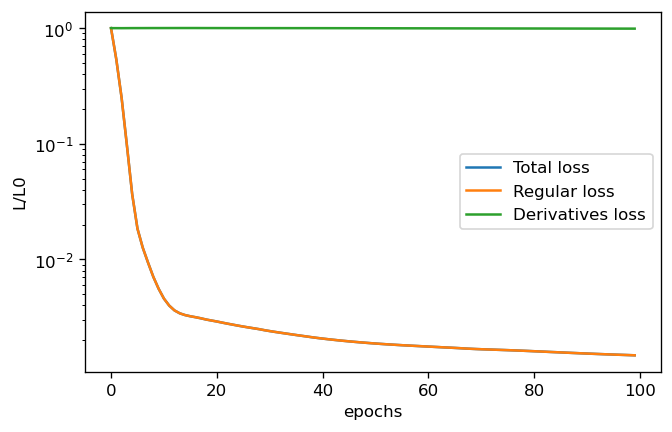

In [7]:
train_y = torch.cat([y_tr_ts, dy_tr_ts], dim = 1)

tstart = time.time()
x, y = Variable(x_tr_ts), Variable(train_y)

net = Net(inp=16, out=1, activation=nn.ReLU(), num_hidden_units=120, num_layers=5)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

BATCH_SIZE = 500
EPOCH = 100
num_data = x_tr_ts.shape[1]
print(num_data)
torch_dataset = Data.TensorDataset(x, y)

loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, num_workers=2, )

# Define derivative loss component to total loss
lam1 = [0.0]
state, lossTotal, lossRegular, lossDerivatives = train(lam1, loader, EPOCH, BATCH_SIZE)
net.load_state_dict(state)

tfinal1 = time.time() - tstart
print (tfinal1)

# Test points


# gradx = getDerivatives(x_va_ts)
plotLoss(lossTotal, lossRegular, lossDerivatives)


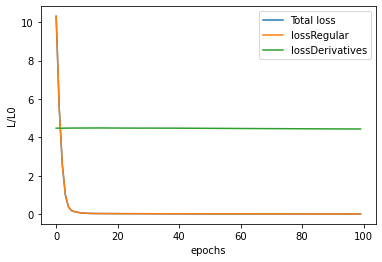

In [8]:
plt.plot(np.arange(len(lossTotal)),lossTotal,label='Total loss')
plt.plot(np.arange(len(lossRegular)),lossRegular,label='lossRegular')
plt.plot(np.arange(len(lossDerivatives)),lossDerivatives,label='lossDerivatives')
plt.xlabel("epochs")
plt.ylabel("L/L0")
plt.legend()

In [9]:
y_prediction = net(x_va_ts)

x_va_ts.requires_grad = True

y_prediction = net(x_va_ts)
y_prediction.sum().backward()
gradx_va = x_va_ts.grad
x_va_ts.requires_grad = False

In [10]:

e_test = np.linalg.norm(y_prediction.detach().numpy()- yV)/np.linalg.norm(yV)
print('e_test is:',e_test*100)

e_test_bar = np.linalg.norm(gradx_va.reshape(-1,1)- dyV.reshape(-1,1))/np.linalg.norm(dyV.reshape(-1,1))
print('e_test_bar is:',e_test_bar*100)



e_test is: 24.417158134750512
e_test_bar is: 99.3218310742547
